## Load and inspect

In [ ]:
!pip install statsmodels

In [44]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

# Optional advanced time-series analysis
try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.seasonal import seasonal_decompose
    HAS_STATSMODELS = True
except ImportError:
    HAS_STATSMODELS = False
    print("⚠️ 'statsmodels' not found — skipping ACF/PACF and decomposition plots.")

## Handle missing values

In [46]:
df = pd.read_csv("../data/processed/merged_fuel_weather_cameroon.csv", parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

print("✅ Dataset loaded successfully!")
print(df.info())


✅ Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5113 entries, 0 to 5112
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                5113 non-null   datetime64[ns]
 1   year_x              5113 non-null   int64         
 2   month_x             5113 non-null   int64         
 3   day                 5113 non-null   int64         
 4   firewood_demand_m3  5113 non-null   float64       
 5   unit                5113 non-null   object        
 6   area                5113 non-null   object        
 7   temperature_avg     5113 non-null   float64       
 8   temperature_min     5113 non-null   float64       
 9   temperature_max     5113 non-null   float64       
 10  rainfall_mm         5113 non-null   float64       
 11  humidity_avg        5113 non-null   float64       
 12  pressure_hpa        5113 non-null   float64       
 13  wind_speed_kmh   

## Split into train and test 

In [47]:
#Chronological split (80/20)

split_ratio = 0.8
split_idx = int(len(df) * split_ratio)
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

print(f"\nTraining Range: {train_df['date'].min()} → {train_df['date'].max()}")
print(f"Testing Range:  {test_df['date'].min()} → {test_df['date'].max()}")



Training Range: 2010-01-01 00:00:00 → 2021-03-13 00:00:00
Testing Range:  2021-03-14 00:00:00 → 2023-12-31 00:00:00


## Scaling the data

In [50]:
# we scale the data to put everything on the same level so that the algorithm has a better sense of the data it is working with
# for best practices we fit only on training data to avoid data leakages 
feature_cols = ['temperature_avg', 'rainfall_mm', 'humidity_avg']
target_cols = ['firewood_demand_m3', 'clean_fuel_access']

cols_to_scale = feature_cols + target_cols
scaler = MinMaxScaler()

train_df.loc[:, cols_to_scale] = scaler.fit_transform(train_df[cols_to_scale])
test_df.loc[:, cols_to_scale] = scaler.transform(test_df[cols_to_scale])

print("\n✅ Data scaled successfully (fit only on train).")



✅ Data scaled successfully (fit only on train).


In [51]:
#Combine scaled back for unified EDA

scaled_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

#  Exploratory Data Analysis (EDA)

### Target trend

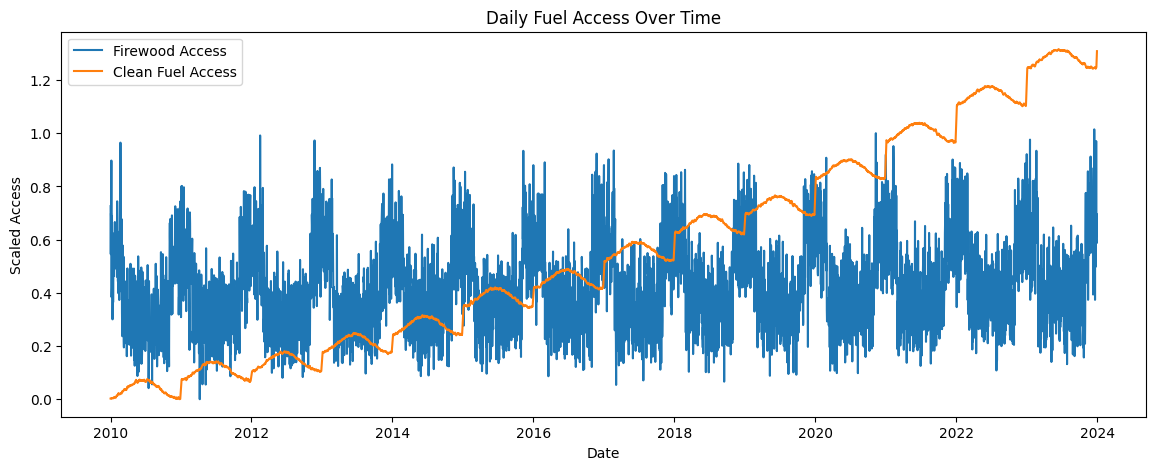

In [53]:

plt.figure(figsize=(14,5))
plt.plot(scaled_df['date'], scaled_df['firewood_demand_m3'], label="Firewood Access")
plt.plot(scaled_df['date'], scaled_df['clean_fuel_access'], label="Clean Fuel Access")
plt.title("Daily Fuel Access Over Time")
plt.xlabel("Date"); plt.ylabel("Scaled Access")
plt.legend()
plt.show()

### Distribution

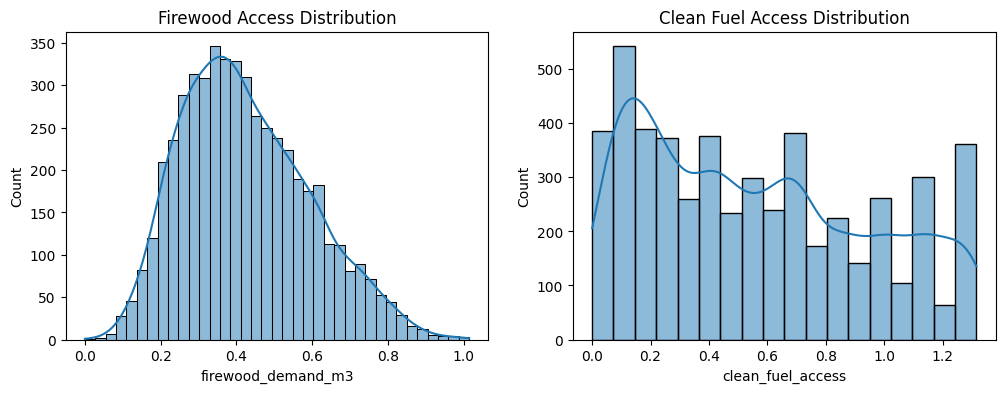

In [55]:

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(scaled_df['firewood_demand_m3'], kde=True)
plt.title("Firewood Access Distribution")
plt.subplot(1,2,2)
sns.histplot(scaled_df['clean_fuel_access'], kde=True)
plt.title("Clean Fuel Access Distribution")
plt.show()



### Seasonal Decomposition

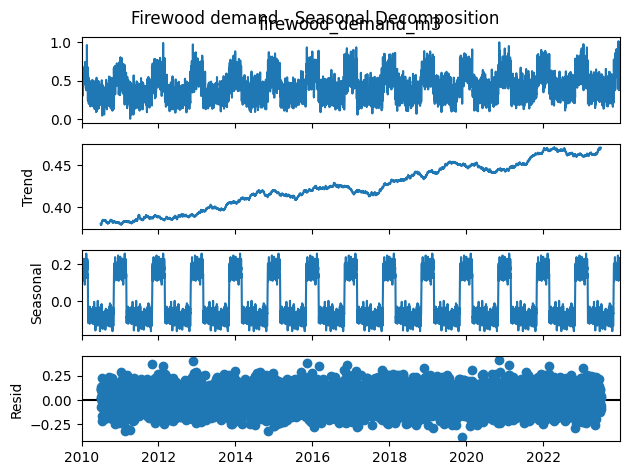

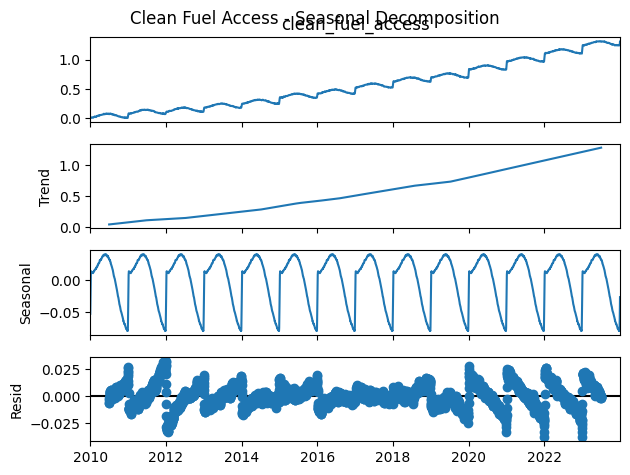

In [56]:
if HAS_STATSMODELS:
    series_fw = scaled_df.set_index("date")['firewood_demand_m3'].asfreq("D")
    decomp_fw = seasonal_decompose(series_fw, model="additive", period=365)
    decomp_fw.plot()
    plt.suptitle("Firewood demand - Seasonal Decomposition")
    plt.show()

    series_cf = scaled_df.set_index("date")['clean_fuel_access'].asfreq("D")
    decomp_cf = seasonal_decompose(series_cf, model="additive", period=365)
    decomp_cf.plot()
    plt.suptitle("Clean Fuel Access - Seasonal Decomposition")
    plt.show()

### ACF/PACF

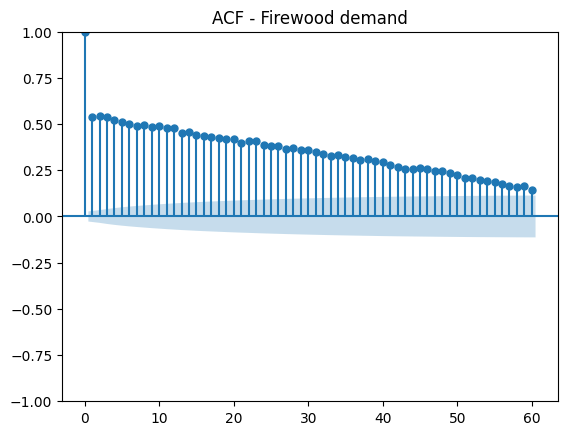

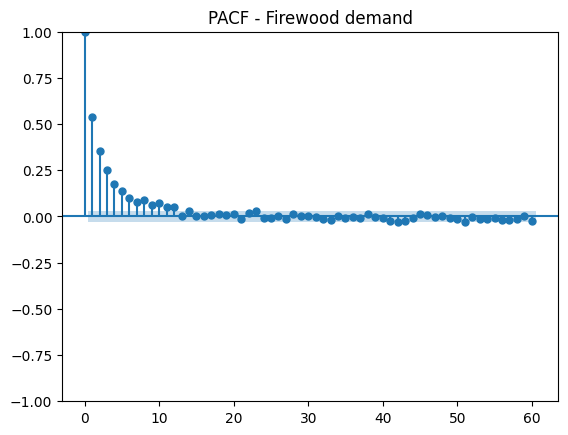

In [57]:
if HAS_STATSMODELS:
    plot_acf(series_fw.dropna(), lags=60)
    plt.title("ACF - Firewood demand")
    plt.show()

    plot_pacf(series_fw.dropna(), lags=60)
    plt.title("PACF - Firewood demand")
    plt.show()

### Correlation matrix

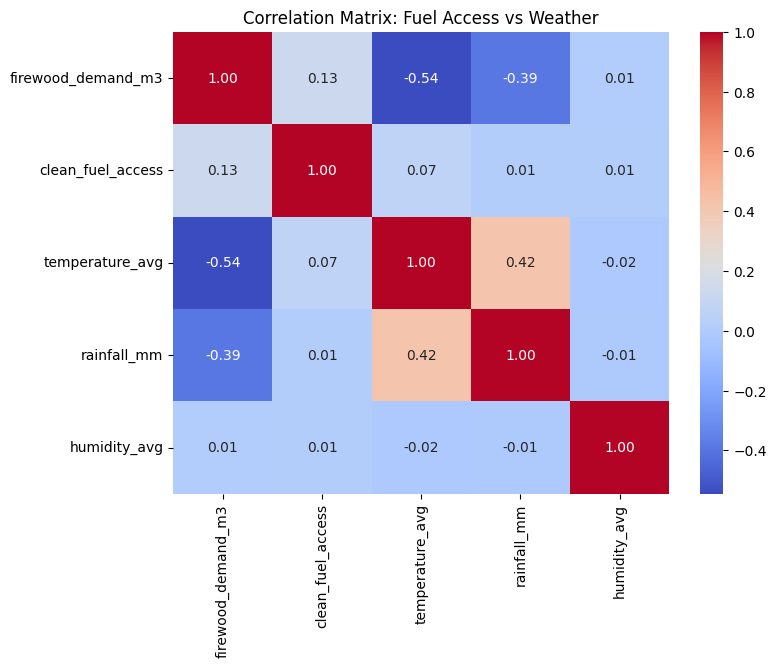

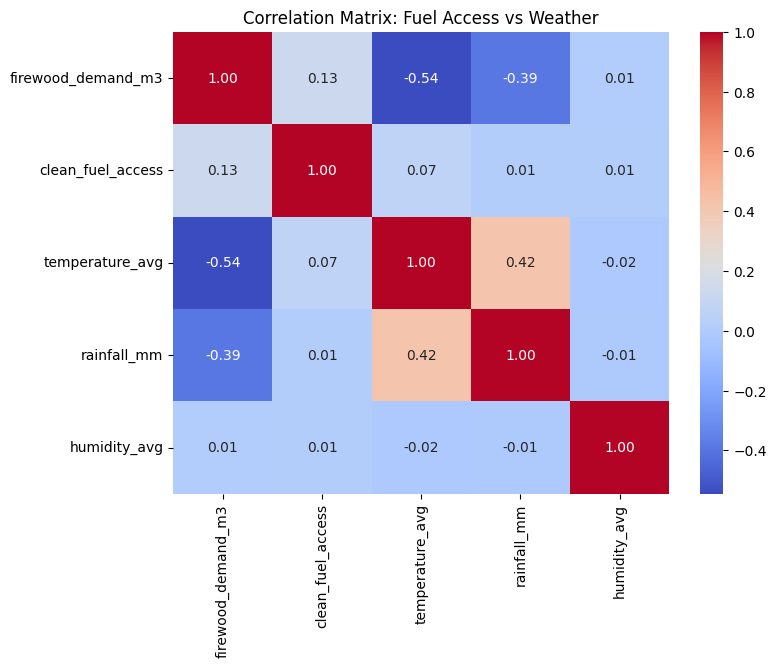

In [60]:
key_vars = ['firewood_demand_m3', 'clean_fuel_access', 'temperature_avg', 'rainfall_mm', 'humidity_avg']
plt.figure(figsize=(8,6))
sns.heatmap(scaled_df[key_vars].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: Fuel Access vs Weather")
plt.show()
key_vars = ['firewood_demand_m3', 'clean_fuel_access', 'temperature_avg', 'rainfall_mm', 'humidity_avg']
plt.figure(figsize=(8,6))
sns.heatmap(scaled_df[key_vars].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: Fuel Access vs Weather")
plt.show()

## Feature engineering

In [62]:
lags = [1, 7, 14, 30]
for lag in lags:
    for col in ['firewood_demand_m3', 'clean_fuel_access']:
        scaled_df[f'{col}_lag_{lag}'] = scaled_df[col].shift(lag)
    for col in ['temperature_avg', 'rainfall_mm']:
        scaled_df[f'{col}_lag_{lag}'] = scaled_df[col].shift(lag)



In [64]:
# Rolling features
windows = [7, 30, 90]
for w in windows:
    scaled_df[f'fw_roll_mean_{w}'] = scaled_df['firewood_demand_m3'].rolling(w).mean()
    scaled_df[f'cf_roll_mean_{w}'] = scaled_df['clean_fuel_access'].rolling(w).mean()
    scaled_df[f'fw_roll_std_{w}'] = scaled_df['firewood_demand_m3'].rolling(w).std()
    scaled_df[f'cf_roll_std_{w}'] = scaled_df['clean_fuel_access'].rolling(w).std()


In [65]:
# Drop NA after lag creation
scaled_df = scaled_df.dropna().reset_index(drop=True)

# Cyclical time features
scaled_df['day_of_year'] = scaled_df['date'].dt.dayofyear
scaled_df['sin_doy'] = np.sin(2 * np.pi * scaled_df['day_of_year'] / 365.25)
scaled_df['cos_doy'] = np.cos(2 * np.pi * scaled_df['day_of_year'] / 365.25)
scaled_df['is_weekend'] = scaled_df['date'].dt.weekday.isin([5,6]).astype(int)

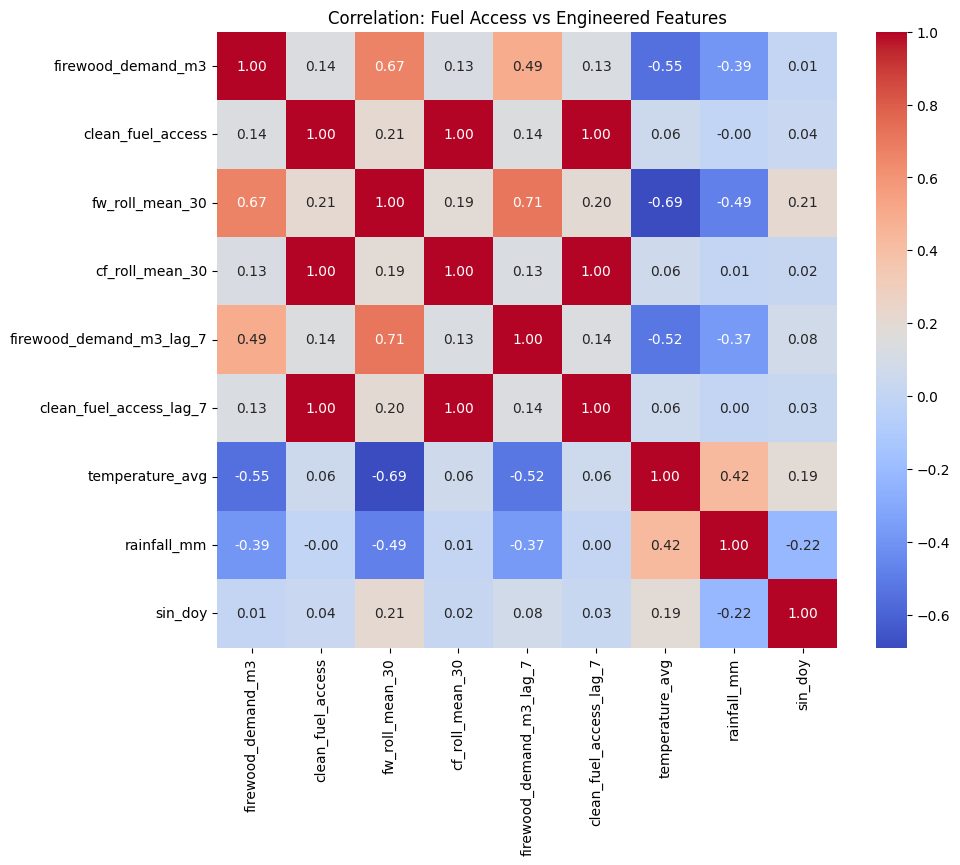

In [67]:
# --- Correlation Check (Subset) ---
subset_cols = [
    'firewood_demand_m3', 'clean_fuel_access',
    'fw_roll_mean_30', 'cf_roll_mean_30',
    'firewood_demand_m3_lag_7', 'clean_fuel_access_lag_7',
    'temperature_avg', 'rainfall_mm', 'sin_doy'
]
plt.figure(figsize=(10,8))
sns.heatmap(scaled_df[subset_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Fuel Access vs Engineered Features")
plt.show()


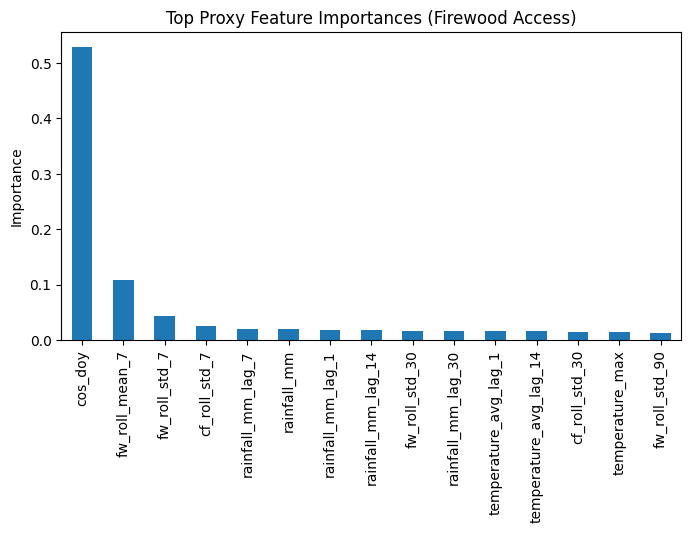

In [68]:
#Proxy Feature Importance 

feature_candidates = [c for c in scaled_df.columns if any(k in c for k in ['temp', 'rain', 'fw_', 'cf_', 'sin_doy', 'cos_doy'])]
X = scaled_df[feature_candidates]
y = scaled_df['firewood_demand_m3']

tscv = TimeSeriesSplit(n_splits=3)
for train_idx, test_idx in tscv.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    break

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)

plt.figure(figsize=(8,4))
feat_imp.plot(kind='bar')
plt.title("Top Proxy Feature Importances (Firewood Access)")
plt.ylabel("Importance")
plt.show()

In [69]:
#Save for LSTM Sequence Creation

scaled_df.to_csv("../data/processed/engineered_scaled_fuel_access.csv", index=False)
print("\n📁 Saved: engineered_scaled_fuel_access.csv")


📁 Saved: engineered_scaled_fuel_access.csv
